In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing, metrics
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

Using TensorFlow backend.


# Supervised learning introduction, K-Nearest Neighbors (KNN)
-----


#### 1. Read data

The provided three files (glass.data, glass.tag, glass.names) contains a small dataset. "[The study of classification of types of glass was motivated by criminological investigation. At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!](https://archive.ics.uci.edu/ml/datasets/Glass+Identification)"

 - read the content of the glass.data file as a pandas dataframe
 - use the column names found in the glass.names file
 - if needed, handle the missing values
 - get rid of the ID column
 - separate the GlassType from the dataset and store it in a one-hot encoded manner (if we have 3 classes, than instead of 1, 2, 3 we use [1, 0, 0], [0, 1, 0] and [0, 0, 1]. So each dimension represents a class and 1 means the sample belongs to that class, 0 is the opposite)
    - be careful, the data contains only 1-2-3-5-6-7, 4 is missing! Convert 5 $\to$ 4, 6 $\to$ 5 and 7 $\to$ 6 and then apply the one-got encoding
    - also keep the converted labels, where y is 1-2-3-4-5-6, we will need them later

In [2]:
data_glasses = pd.read_csv("glass.data", names=['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'])
data_glasses.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In the first exercise, we needed to read in the data. The labels were found in one of the documents. They correspond to the following properties:

 - 1. Id number: 1 to 214
 - 2. RI: refractive index
 - 3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
 - 4. Mg: Magnesium
 - 5. Al: Aluminum
 - 6. Si: Silicon
 - 7. K: Potassium
 - 8. Ca: Calcium
 - 9. Ba: Barium
 - 10. Fe: Iron
 - 11. Type of glass: (class attribute)
      -- 1 building_windows_float_processed
      -- 2 building_windows_non_float_processed
      -- 3 vehicle_windows_float_processed
      -- 4 vehicle_windows_non_float_processed (none in this database)
      -- 5 containers
      -- 6 tableware
      -- 7 headlamps
      
Let's get rid of the ID column:

In [3]:
data_glasses_no_id = data_glasses.drop(columns = ['Id'])
data_glasses_no_id.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Let's check if there are some missing values:

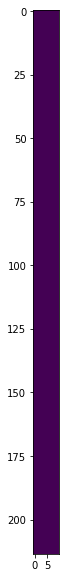

In [4]:
plt.figure(figsize=(1,10))
plt.imshow(data_glasses_no_id.isna())
plt.show()

As it's seen, there seem to be no missing values. 

In the next exercise, we will replace the given type of glasses' values. Since there are no #4 values, we will convert 5  →  4, 6  →  5 and 7  →  6. This is done by the following codes:

In [5]:
data_glasses_replaced = data_glasses_no_id
data1 = data_glasses_replaced['Type'].replace(5, 4)
data1 = data1.replace(6, 5)
data1 = data1.replace(7, 6)

data_glasses_replaced['Type'] = data1
data_glasses_replaced.tail(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
209,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,6
210,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,6
211,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,6
212,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,6
213,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,6


As it's seen, the replacement was successful! Now we will have to onehotencode the data. For this, I'll be using the 'to_categorical' function of keras. 

In [6]:
data = np.array(data_glasses_replaced['Type'])
encoded = to_categorical(data, dtype = int)
encoded

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

We successfully onehotencoded the data. A small problem accured in the process. This function created the categorical matrix from 0 to 6. We only havevalues from 1 to 6, so we have to drop the first row. This is done in the following, when we create a pandas dataframe from the matrix and then append it to the original 'data_glasses_replaced' dataframe.

In [7]:
type_matrix = pd.DataFrame(encoded)
type_matrix = type_matrix.drop(columns=[0])

data_glasses_encoded = data_glasses_replaced.join(type_matrix)
data_glasses_encoded.tail()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,1,2,3,4,5,6
209,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,6,0,0,0,0,0,1
210,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,6,0,0,0,0,0,1
211,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,6,0,0,0,0,0,1
212,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,6,0,0,0,0,0,1
213,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,6,0,0,0,0,0,1


Let's normalize the dataset!

In [8]:
list_of_names = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

for i in list_of_names:
    mean_value = np.mean(data_glasses_encoded[i])
    std_value = np.std(data_glasses_encoded[i])
    data_glasses_encoded[i] = (data_glasses_encoded[i]-mean_value)/std_value

data_glasses_encoded.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,1,2,3,4,5,6
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1,1,0,0,0,0,0
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1,1,0,0,0,0,0
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1,1,0,0,0,0,0
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1,1,0,0,0,0,0
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1,1,0,0,0,0,0


#### 2. \& 3. Implement KNN

Implement the K-nearest neighbors regression algorithm using only pure Python3 and numpy! Use L2 distance to find the neighbors. The prediction for each class should be the number of neighbors supporing the given class divided by **k** (for example if **k** is 5 and we have 3 neighbors for class A, 2 for class B and 0 for class C neighbors, then the prediction for class A should be 3/5, for class B 2/5, for class C 0/5). 

Complete the function!

```python
def knn_classifier(k, X_train, y_train, X_test):
    ...
    return predictions
```
 - **k** is the number of neighbors to be considered
 - **X_train** is the training data points
 - **X_test** is the test data points
 - **y_train** is the labels for the training data
 - assume that **y_test** is one-hot encoded.

A valid-syntaxed input looks like:
````python
k = 2
X_train = [[0.9, 0.2, 0.8] , [-1.2, 1.5, 0.7], [5.8, 0.0, 0.9], [6.2, 0.9, 0.9]]
y_train = [[0, 1], [0, 1], [1, 0], [0, 1]]
X_test  = [[0.8, 0.8, 0.6], [0.5, 0.4, 0.3]]
```

Here, it means that the training data consists of 4 points, each point is placed in a 3 dimensional space. And there are two possible classes for each point and there are two data points for that predictions is needed.

Let's implement the KNN algorithm:

In [9]:
def knn_classifier(k, X_train, y_train, X_test):
    
    results_for_different_k = []
    
    for i in range(0,len(X_test)):
        x_test_dist = []
        x_test_data = []
        for j in range(0,len(X_train)):
            dst = distance.euclidean(X_test[i], X_train[j])
            x_test_data.append(dst)
            x_test_dist.append(dst)
        
        #sorting the data:
        x_test_sorted = x_test_dist
        x_test_sorted.sort()
        
        #saving the amount of points which are needed:
        saved_items = []
        for l in range(0,k):
            index_of_value = x_test_data.index(x_test_sorted[l])
            saved_items.append(y_train[index_of_value])
        
        #adding up the values to get the possible fractions for the nearest neighbours:
        array_of_results = np.sum(saved_items, axis = 0)/len(saved_items)
        results_for_different_k.append(array_of_results)        
        
    return(results_for_different_k)
    #return(saved_items)
    #return(x_test_data)

Now all we have to do is giving some example data to the algorithm and run it. The results are saved in the "k_nearest_neighbours" array:

In [10]:
k = 2
X_train = [[0.9, 0.2, 0.8] , [-1.2, 1.5, 0.7], [5.8, 0.0, 0.9], [6.2, 0.9, 0.9]]
y_train = [[0, 1], [0, 1], [1, 0], [0, 1]]
X_test  = [[0.8, 0.8, 0.6], [0.5, 0.4, 0.3]]

k_nearest_neighbours = knn_classifier(k, X_train, y_train, X_test)
k_nearest_neighbours

[array([0., 1.]), array([0., 1.])]

#### 4. Predictions & interpretation

- use every second (0, 2, 4, etc indicies) datapoint as training data and use the rest (1, 3, 5, ...) as test data
- generate predictions with the implemented KNN with k=5
- calculate the accuracy and the confusion matrix for the predictions
- if the probability is the same for two or more classes select the first one from the left in the one-hot encoded version (or which has the smallest number in the original dataset)

Creating arrays for the input:

In [11]:
data_no_type_encoded = data_glasses_encoded 
data_no_type_encoded = data_no_type_encoded.drop(columns=['Type'])
array_of_encoded = data_no_type_encoded.to_numpy()

list_of_attribute_values_train = []
list_of_attribute_values_test = []
list_of_encoded_train = []
list_of_encoded_test = []

for i in range(0,len(array_of_encoded)):
    if i% 2 == 0:
        list_of_attribute_values_train.append(array_of_encoded[i][0:9])
        list_of_encoded_train.append(array_of_encoded[i][9:15])
    else:
        list_of_attribute_values_test.append(array_of_encoded[i][0:9])
        list_of_encoded_test.append(array_of_encoded[i][9:15])

Running the algorithm on our dataset and saving the solution in a matrix, which is still in onehotencoded form:

In [12]:
k = 5
X_train = list_of_attribute_values_train
y_train = list_of_encoded_train
X_test  = list_of_attribute_values_test

k_nearest_neighbours = knn_classifier(k, X_train, y_train, X_test)

solution_of_encoded_matrix = []

for i in range(0,len(k_nearest_neighbours)):
    array_of_zeros = np.zeros(6)

    list_of_values = k_nearest_neighbours[i].tolist()
    index_of_max = list_of_values.index(np.max(list_of_values))

    array_of_zeros[index_of_max] = 1
    solution_of_encoded_matrix.append(array_of_zeros)

Let's calculate the accuracy! I'll compare the 'solution_of_encoded_matrix' to the original dataset's onehotencoded matrix: 'list_of_encoded_test'.

In [13]:
correct = 0
incorrect = 0

for i in range(0,len(solution_of_encoded_matrix)):
    if sum(abs(solution_of_encoded_matrix[i] - list_of_encoded_test[i])) == 0:
        correct += 1
    else:
        incorrect += 1
        
accuracy = correct/(correct+incorrect)*100
        
print('The accuracy of the manual KNN method is: ' + "%.4f" % round(accuracy, 4) + '%')

The accuracy of the manual KNN method is: 72.8972%


In [14]:
#converting the arrays to lists:

y_real = []
y_pred = []
y_pred_original = []
y_real_original = []

for i in range(0,len(solution_of_encoded_matrix)):
    y_pred.append(list(map(int, solution_of_encoded_matrix[i])))
    y_real.append(list(map(int, list_of_encoded_test[i])))

In [15]:
#getting back the original data from onehotencoding:

y_pred_data = []
y_real_data = []

for i in range(0,len(y_pred)):
    array_of_pred = y_pred[i]
    index_of_element_pred = array_of_pred.index(1) + 1
    y_pred_data.append(index_of_element_pred)
    
for i in range(0,len(y_real)):
    array_of_real = y_real[i]
    index_of_element_real = array_of_real.index(1) + 1
    y_real_data.append(index_of_element_real)

Let's see what the confusion matrix looks like!

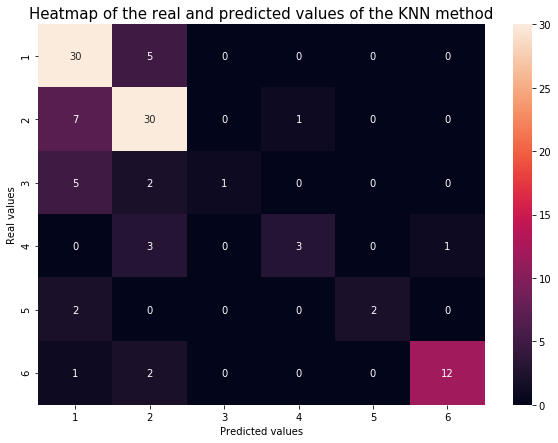

In [16]:
confusion_matrix_values = confusion_matrix(y_real_data, y_pred_data)#, label=['1','2','3','4','5','6'])

plt.subplots(figsize=(10,7))
x_axis_labels = ['1','2','3','4','5','6']
y_axis_labels = ['1','2','3','4','5','6']
p1 = sns.heatmap(confusion_matrix_values, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt="d")

plt.ylabel('Real values')
plt.xlabel('Predicted values')
plt.title('Heatmap of the real and predicted values of the KNN method', fontsize=15)
plt.show()

#### 5. Compare it to Sklearn's KNN
- using the same train/test split generate predictions with sklearn KNNs. Use 5 neighbors again
- are the predictions the same as for our implementation? (they should be)
   - note: to get sklearn perform the same algorithm as out implementation it expects you to provide non one-hot encoding labels. That's why we kept them in the first exercise

In [29]:
#importing the knn model and running it:

model = KNeighborsClassifier(n_neighbors=5)
model.fit(list_of_attribute_values_train, y_real_data)
knn_predicted = model.predict(list_of_attribute_values_test)

print('The accuracy of the Scikit KNN method is: ' + "%.4f" % round(100*metrics.accuracy_score(knn_predicted, y_real_data), 4) + '%')

The accuracy of the Scikit KNN method is: 72.8972%


The manual knn model had the accuracy of 72.8972%. This model has the exact same accuracy. This means that our algorithm for the knn method is working fine.

In conclusion we can say, that these models are both considered accurate.